In [1]:
import os
import sys
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
sys.path.append('../')
from numpy import pi, log
import numpy as np
import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior, SortedUniformPrior
try:
    from mpi4py import MPI
except ImportError:
    pass
from interpax import CubicSpline
from gwb.omega_gw_jax import OmegaGWjax
import jax
jax.config.update("jax_enable_x64", True)
from numpyro.util import enable_x64
enable_x64()
from interpolation.model import spline_predict
from numpyro.contrib.nested_sampling import NestedSampler
import numpyro.distributions as dist
import numpyro
import jax.numpy as jnp
from jax import jit, random
import matplotlib.pyplot as plt


[Ameeks-Air.lan:01790] shmem: mmap: an error occurred while determining whether or not /var/folders/sq/_30b3rn56vz_g8gd5ts_jzf40000gn/T//ompi.Ameeks-Air.501/jf.0/2929262592/sm_segment.Ameeks-Air.501.ae990000.0 could be created.


(40,)


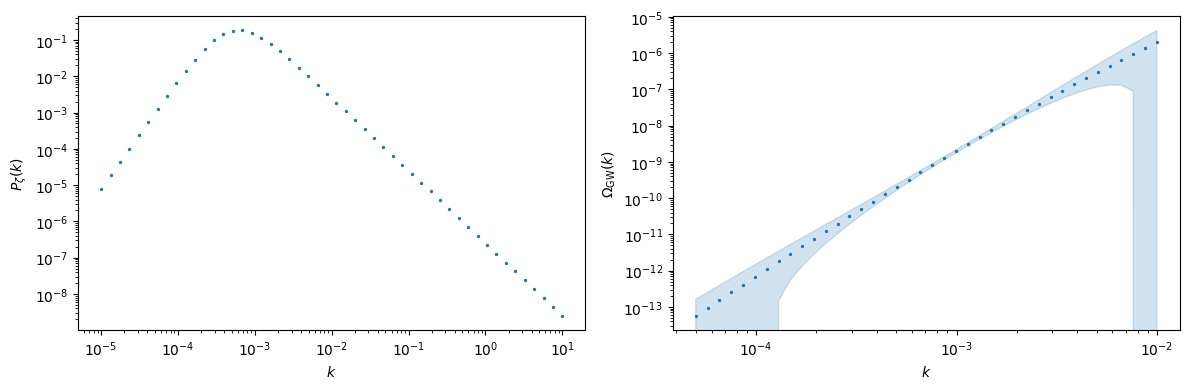

In [2]:
# set up the power spectrum and omgw
psize = 50
ksize = 40
k_arr = jnp.geomspace(5e-5,1e-2,ksize)
p_arr = jnp.geomspace(1e-5,1e1,psize)


f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1, 10)  # First rescaled internal momentum
t = jnp.logspace(-3,3, 100)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

pstar=5e-4
n1=3
n2=-2
sigma=2

@jit
def pz(p,kmax,etaR):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return pl1 * pl2 #*osc

gwb_calculator =  OmegaGWjax(s, t, f=f, kernel="I_MD_to_RD", upsample=False,norm="CT")

kmax = 5e-3
etaR = 1./kmax
transition_params = [kmax,etaR]

pz_amp = pz(p_arr,*transition_params)
gwb_amp = gwb_calculator(pz,f,*transition_params)
kstar = 1e-3
omks_sigma = gwb_amp*( 0.1*(np.log(k_arr/kstar))**2 + 0.05) # 2% error at kstar + more towards edges
gwb_cov = jnp.diag(omks_sigma**2)

print(gwb_amp.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(p_arr,pz_amp,s=2)
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.scatter(f,gwb_amp,s=2)
ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='C0')
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout();

In [7]:
fac = 2.5
kmin, kmax = min(k_arr)/fac, max(k_arr)*fac
n = 4
nodes = jnp.log10(jnp.geomspace(kmin, kmax, n))
print(f"best node amplitudes: {jnp.log10(pz(10**nodes, *transition_params))}")
ymin, ymax = -10, 1
k1, k2 = -3, 0

def model():
    ys = numpyro.sample("ys", dist.Uniform(ymin, ymax,).expand([n]))
    kmax = numpyro.sample("kmax", dist.Uniform(k1, k2))
    kmax = 10**kmax
    etaR = 1./kmax
    pz_interp = lambda k, kmax, etaR: spline_predict(nodes, ys, k)
    gwb = gwb_calculator(pz_interp, f, kmax, etaR)
    numpyro.sample("gwb", dist.MultivariateNormal(gwb_amp, gwb_cov), obs=gwb)

constructor_kwargs  = {'max_samples': 1e5,'parameter_estimation': True, 'difficult_model': True, 'verbose': False}
termination_kwargs = {'dlogZ': 0.001}
ns = NestedSampler(model,constructor_kwargs=constructor_kwargs,termination_kwargs=termination_kwargs)
ns.run(random.PRNGKey(0),)
ns.print_summary()
    # samples obtained from nested sampler are weighted, so
    # we need to provide random key to resample from those weighted samples
ns_samples = ns.get_samples(random.PRNGKey(1), num_samples=1000)

# def prior(x):
#     ndim = len(x)
#     x[:ndim-1] = x[:ndim-1]*(ymax-ymin) + ymin
#     x[ndim-1] = x[ndim-1]*(k2-k1) + k1
#     return x

# def loglikelihood(params):
#     ys = params[:-1]
#     kmax = params[-1]
#     kmax = 10**kmax
#     etaR = 1./kmax
#     pz_interp = lambda k, kmax, etaR: spline_predict(nodes, ys, k)
#     gwb = gwb_calculator(pz_interp,f,kmax,etaR)
#     return -0.5*jnp.dot(gwb - gwb_amp, jnp.linalg.solve(gwb_cov, gwb - gwb_amp)) 

best node amplitudes: [-4.19555582 -1.28181369 -1.38259415 -3.39837422]


INFO:jaxns:Number of Markov-chains set to: 20


Running over 8 devices.
--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 453920
samples: 4352
phantom samples: 3600
likelihood evals / sample: 104.3
phantom fraction (%): 82.7%
--------
logZ=860.74 +- 0.91
max(logL)=879.64
H=-17.31
ESS=53
--------
kmax: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
kmax: -2.142 +- 0.016 | -2.163 / -2.142 / -2.121 | -2.164 | -2.164
--------
ys[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
ys[0]: -1.27 +- 0.11 | -1.41 / -1.23 / -1.14 | -1.16 | -1.16
ys[1]: -0.597 +- 0.039 | -0.646 / -0.591 / -0.55 | -0.548 | -0.548
ys[2]: -1.26 +- 0.026 | -1.288 / -1.261 / -1.222 | -1.274 | -1.274
ys[3]: -2.829 +- 0.046 | -2.891 / -2.826 / -2.774 | -2.896 | -2.896
--------


(8, 50)


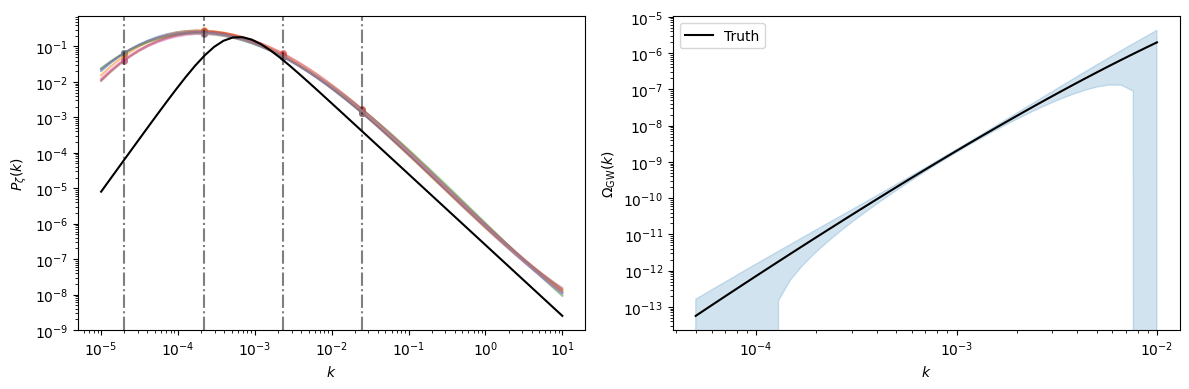

In [6]:
thin_factor = 128

ys = ns_samples['ys'][::thin_factor]
kmaxs = ns_samples['kmax'][::thin_factor]
etaRs = 1/kmaxs
def omega_f(y,kmax,etaR):
    pz_interp = lambda k, kmax,etaR: spline_predict(x_train=nodes,y_train=y,x_pred=k)
    gwb = gwb_calculator(pz_interp,k_arr,kmax,etaR)    
    return gwb
gwb_amps = jax.vmap(omega_f,)(ys,kmaxs,etaRs)

ff = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=p_arr)
pz_amps = jax.vmap(ff,)(ys)
print(pz_amps.shape)
# gwb_amps = jnp.einsum("pi,pj,kij->pk",pz_amps,pz_amps,gwb_calculator.omkij)
# print(gwb_amps.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

for i,pzs in enumerate(pz_amps):
    ax1.loglog(p_arr,pzs,alpha=0.5)
    ax1.scatter(10**(nodes),10**(ys[i]),s=16,alpha=0.5)
# print(gwb_amps.shape)
# print(gwb_amps[3])
for om in gwb_amps:
    ax2.loglog(k_arr,om,alpha=0.5)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,gwb_amp,color='k',lw=1.5,label='Truth')
ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
# ax2.set_ylim(1e-5,1.)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(10**(val),color='k',ls='-.',alpha=0.5)
fig.tight_layout()

In [ ]:
ys = jnp.array([-3.9,-1.86,-1.85,-3.2])